In [1]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define Data

from utils import *
from stpy.borel_set import BorelSet

obs, dt, gdf = get_taxi_data(200)
obs = obs.to(device)

obs_pos = obs[obs[:, 0] > 0]
obs_neg = obs[obs[:, 0] > 0]

# Define the grid size
grid_size = 50
domain = BorelSet(2, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double())

# Create evenly spaced values between -1 and 1
x_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)
y_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)

# Initialize the count tensor
counts = torch.zeros((grid_size, grid_size), dtype=torch.float64)

# Count the number of points in each bin
for point in obs:
    x_idx = torch.searchsorted(x_edges, point[0], right=True) - 1
    y_idx = torch.searchsorted(y_edges, point[1], right=True) - 1
    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size:
        counts[x_idx, y_idx] += 1

counts = counts.view(-1)
x = get_grid(grid_size, -1, -1, 1, 1)
area_per_grid = 4.0 / (grid_size ** 2)

In [4]:
# Define the Process

from functools import partial
import numpy as np
import scipy
from stpy.kernels import KernelFunction
from tqdm import tqdm
from autograd_minimize import minimize
import torch
from typing import List
from logcox_process import LogCoxProcess


kernel_object = KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2)
process = LogCoxProcess(kernel_object, 60)

In [5]:
# MAP by representer theorem with two areas

process.load_data(
    [
        (
            BorelSet(2, bounds=torch.tensor([[0, 1.0], [-1, 1]]).double()),
            obs_pos,
            1.0,
        ),
        (
            BorelSet(2, bounds=torch.tensor([[-1.0, 0], [-1, 1]]).double()),
            obs_neg,
            1.0,
        ),
    ]
)

intensity = process.fit()
map = process.rate_value(x, 1.0)

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return func(*args, **kwargs)


optimum found


In [6]:
# MALA

gamma_map = process.get_gamma_MAP(counts, x, torch.tensor(2.0 / 900.0), lr=0.005)
print("Got Gamma MAP")
samples_list = [
    s
    for s in process.sample_mala(
        counts, x, torch.tensor(4.0 / 900.0), 0.06, 600, 200, gamma_map
    )
]
samples = torch.stack(samples_list)

Optimizing gamma:  28%|██▊       | 2836/10000 [00:05<00:13, 526.54it/s]


Solved to eps
Got Gamma MAP
nan


/tmp/ipykernel_193118/3966405151.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xtest_orig = np.array(get_grid(grid_size, left, down, right, up).cpu())


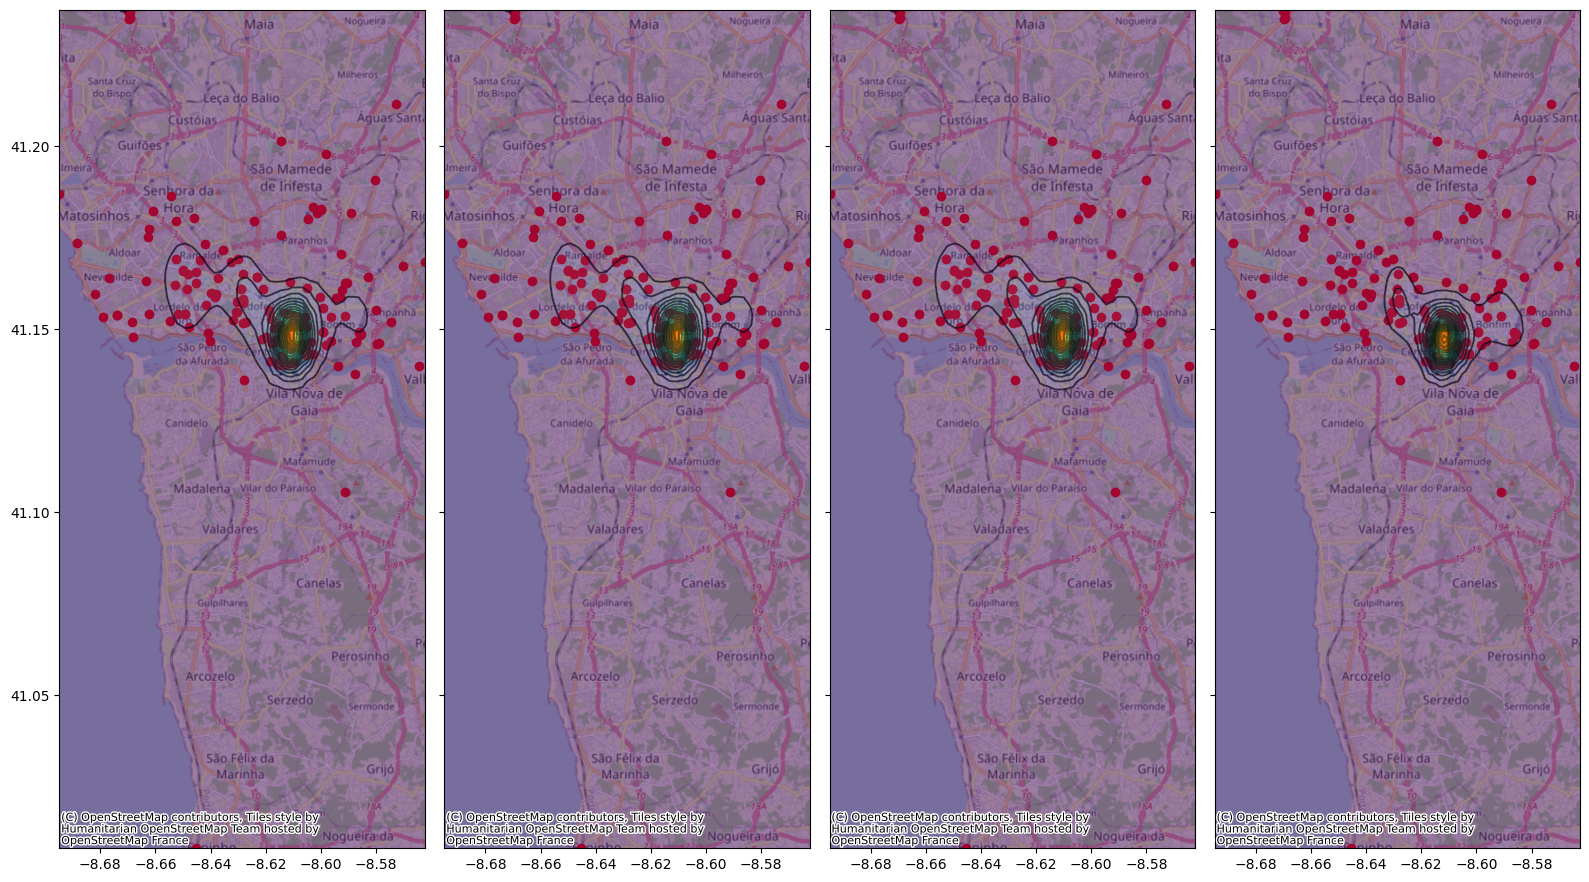

In [7]:
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sympy import S


xtest = domain.return_discretization(grid_size)
left, down, right, up = gdf.total_bounds
xtest_orig = np.array(get_grid(grid_size, left, down, right, up).cpu())

k = 3  # number of samples to draw and plot

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]
grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]

# Set up the plot
fig, axs = plt.subplots(1, k + 1, figsize=(5 * k + 1, 10), sharey=True)

# Sample and plot for each subplot
for i in range(k + 1):
    # Get one intensity estimate
    if i < k:
        s = samples[0]
    else:
        s = process.rate_value(xtest).squeeze(1)

    # Interpolate function values for contour plot
    f = griddata((xx, yy), s.cpu().numpy(), (grid_x, grid_y), method="linear")

    # Plot on subplot
    ax = axs[i]
    gdf.plot(ax=ax, color="red", figsize=(10, 10))
    cs = ax.contourf(grid_x, grid_y, f, levels=20, alpha=0.5)
    ax.contour(cs, colors="k", alpha=0.5)
    ctx.add_basemap(ax, crs=gdf.crs.to_string())

plt.tight_layout()
plt.show()

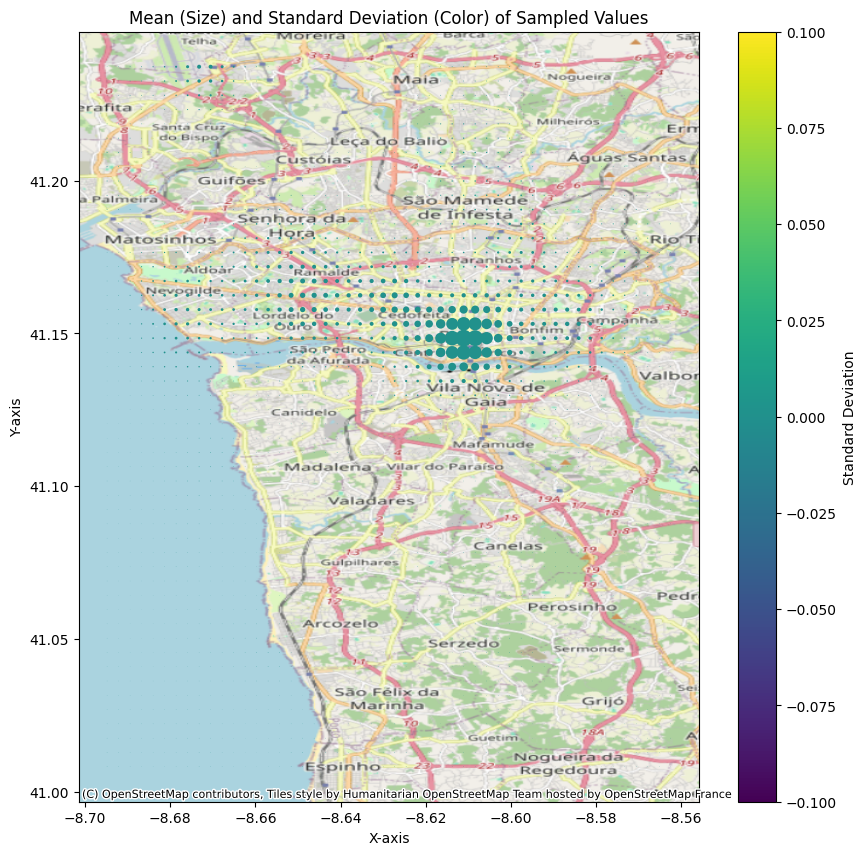

In [8]:


# Prepare coordinates for plotting
xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

# Calculate mean and standard deviation across samples at each point
mean_values = torch.mean(samples, dim=0)
std_values = torch.std(samples, dim=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Define a scaling factor for the sizes based on mean values
scale_factor = 0.1  # Adjust this factor as needed for visual clarity

# Scatter plot with mean values as size and std as color using viridis colormap
scatter = ax.scatter(
    xx,
    yy,
    c=std_values.cpu(),
    cmap="viridis",
    s=mean_values.cpu() * scale_factor,  # Scale point size by mean values
    alpha=1.0,
    edgecolor="face",
    linewidth=0.0,
    marker="o",
)

ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Color bar for the standard deviation (variance)
cbar = fig.colorbar(scatter, ax=ax, label="Standard Deviation")

# Labeling
ax.set_title("Mean (Size) and Standard Deviation (Color) of Sampled Values")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

In [9]:
print(
    f"Mean in [{torch.min(mean_values)}, {torch.max(mean_values)}] and std in"
    f" [{torch.min(std_values)}, {torch.max(std_values)}]"
)

Mean in [0.2526008942351684, 1477.5561130521444] and std in [0.0, 0.0]


In [10]:
mean_expected_num_points = torch.tensor(4.0 / 900.0) * mean_values.sum(0)
mean_expected_num_points

tensor(182.9127, device='cuda:0')

In [11]:
# approximate integral
weights, nodes = BorelSet(2, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double()).return_legendre_discretization(100)
weights = weights.to(device)
nodes = nodes.to(device)
map_expected_num_points = (weights * intensity(nodes)).sum()
map_expected_num_points

tensor(650576.3309, device='cuda:0')